## Music Genre Classification with Unsupervised Learning

In this project we will explore the use of unsupervised learning algorithms applied to audio musical data for the purpose of classifying the genre of the music contained within the files. The dataset for this project is found on a kaggle competition located at https://www.kaggle.com/competitions/kaggle-pog-series-s01e02/overview.

The total data provided contains more than 30,000 royalty free song samples, each clip being of 30 seconds length and also labelled with their musical genre. We will carry out an exploratory data analysis to gain an understanding of the dataset, extract features from the samples, and then attempt to apply an unsupervised algorithm to classify the music samples by their genre. 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [41]:
import os
print(os.listdir('/kaggle/working'))

['__notebook_source__.ipynb', '.virtual_documents', 'more_features.npy']


## Exploratory Data Analysis
Let's import some of the libraries we will need to undertand the dataset we have been provided. 

In [3]:
import numpy as np 
import pandas as pd 
import librosa
import librosa.display

import IPython.display as idp
from tqdm import tqdm

pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

Now we will load the training and test data and follow with some basic metrics that describe the data we are are going to work with 

In [4]:
# Load the data identifying the training and test sets 
train_df = pd.read_csv('../input/kaggle-pog-series-s01e02/train.csv')
test_df = pd.read_csv('../input/kaggle-pog-series-s01e02/test.csv')
# A file showing the different genres within our data
genre = pd.read_csv('../input/kaggle-pog-series-s01e02/genres.csv')

In [5]:
print(' Number of files in the training dataset:', train_df.shape[0], '\n Number of columns in the training data:',train_df.shape[1])

 Number of files in the training dataset: 19922 
 Number of columns in the training data: 5


In [6]:
train_df.head(20)

,song_id,filename,filepath,genre_id,genre
0,10150,010150.ogg,train/010150.ogg,7,Instrumental
1,7358,007358.ogg,train/007358.ogg,2,Punk
2,20573,020573.ogg,train/020573.ogg,5,Folk
3,11170,011170.ogg,train/011170.ogg,12,Old-Time / Historic
4,16662,016662.ogg,train/016662.ogg,1,Rock
5,1019,001019.ogg,train/001019.ogg,1,Rock
6,11198,011198.ogg,train/011198.ogg,9,International
7,23169,023169.ogg,train/023169.ogg,6,Chiptune / Glitch
8,839,000839.ogg,train/000839.ogg,9,International
9,22444,022444.ogg,train/022444.ogg,3,Experimental


Next we have a look at all the genres contained within our training data and the counts of the music genres. 
We plot a histogram for easy visualisation of the distribution of genres within our data.

In [7]:
genre_dist = pd.DataFrame(train_df.groupby('genre').count()['genre_id']).sort_values(by='genre_id', ascending = False)
genre_dist

,genre_id
genre,
Rock,3097
Electronic,3073
Punk,2584
Experimental,1801
Hip-Hop,1761
Folk,1215
Chiptune / Glitch,1181
Instrumental,1045
Pop,945


<AxesSubplot:xlabel='genre'>

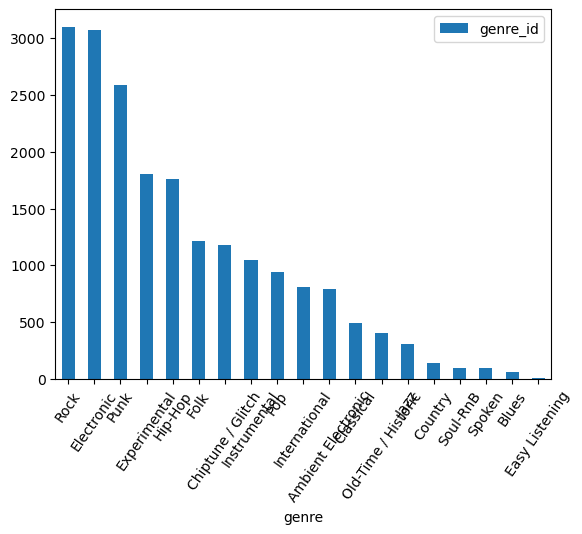

In [8]:
genre_dist.plot.bar(rot=55)

A glance at the previous table and bar plot alerts us immediately that our dataset is very unbalanced. This is noted and will be taken into consideration when we apply our machine learning techniques further ahead, in this case fo rthe purpose of clustering. 

### Further explorations:
At this point we will have a look at some unique aspects of dealing with data in audio form and the type features that can be extracted from audio files.

We first recognise that audio signals are propagated as waves that can be visualised by frequency graphs, showing amplitude and other physical characteristics of the wave plotted against elapsed time. We will make extensive use of the 'librosa' python library in our manipulation and of the audio files. 

Let's load one 30 second music file. I have chosen a file under the genre 'Rock'. 

In [9]:
y,sr = librosa.load('../input/kaggle-pog-series-s01e02/train/016662.ogg')
# print('y:',y,'\n')
# print('y shape:',np.shape(y),'\n')
# print('Sample Rate (KHz):',sr, '\n')

# print('Length of Audio:', len(y)/sr)

We can confirm the music is what we expect from a Rock song by listening to our short clip.

In [10]:
idp.display(idp.Audio('../input/kaggle-pog-series-s01e02/train/016662.ogg'))

One way of having a visual representation of audio data is to plot a spectrogram as shown below for our sample Rock music file. 

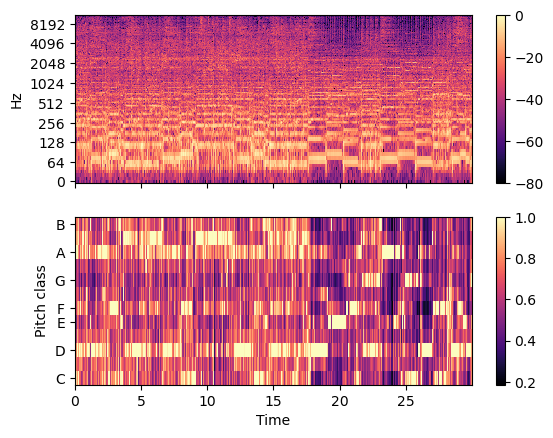

In [11]:
S = np.abs(librosa.stft(y))
chroma = librosa.feature.chroma_stft(S=S, sr=sr)

fig, ax = plt.subplots(nrows=2, sharex=True)
img = librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                               y_axis='log', x_axis='time', ax=ax[0])
fig.colorbar(img, ax=[ax[0]])
ax[0].label_outer()
img = librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', ax=ax[1])
fig.colorbar(img, ax=[ax[1]])

We will contrast this with a sample file from the 'Hip-Hop' genre. Using the code below we can have a listen and follow it with a spectrogram plot. 

In [12]:
y2,sr2 = librosa.load('../input/kaggle-pog-series-s01e02/train/012275.ogg')
idp.display(idp.Audio('../input/kaggle-pog-series-s01e02/train/012275.ogg'))

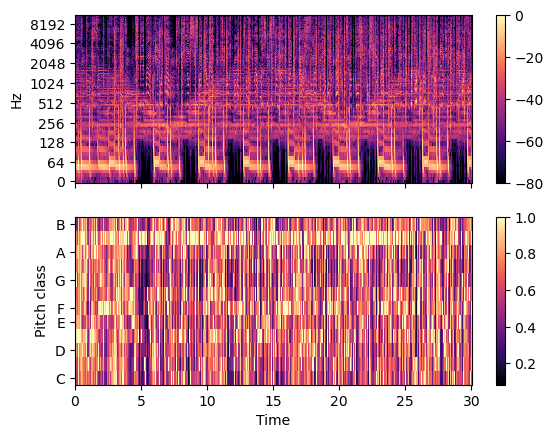

In [13]:
S2 = np.abs(librosa.stft(y2))
chroma2 = librosa.feature.chroma_stft(S=S2, sr=sr2)

fig, ax = plt.subplots(nrows=2, sharex=True)
img = librosa.display.specshow(librosa.amplitude_to_db(S2, ref=np.max),
                               y_axis='log', x_axis='time', ax=ax[0])
fig.colorbar(img, ax=[ax[0]])
ax[0].label_outer()
img = librosa.display.specshow(chroma2, y_axis='chroma', x_axis='time', ax=ax[1])
fig.colorbar(img, ax=[ax[1]])

Clearly, there are differences between the 2 spectrograms on close inspection. Even though it may be hard to make sense or identify a pattern, we can see that visually the 2 files are different which indicates to us that we may be able to capture certain characteristics of the sound forms that will be useful for our task. 

## General Plan of Approach
Our aim is to use a Non-negative Matrix Factorisation (NMF) algorithm to classify our audio data into distinct music genres. This is an unsupervised machine learning algorithm that works by factorising a single matrix of our data features into a product of 2 new matrices such that some latent features are generated which allow us to separate our data into clusters. It crucially requires that all entries in our feature matrix are positive or equal to zero.

The 3 steps we will follow in our study are as follows:
- perform minor cleaning procedures to further process our data
- make use of the 'librosa' library to generate or extract a number of audio-specific features from our data
- feed the generated features from the previous step into our NMF model and evaluate it's performance using some accuracy metrics. 

#### Data clean-up, minor
We want to reduce our data to meet 2 requirements: First we will only work with a subset of the data that is limited to 3 or 4 target categories - music genres in this case. Second, we will choose these in a manner that ensures our working data is better balancd among our choice genre subset, as we have seen that our total dataset is very imbalanced.

In [14]:
# create a smaller subset by choosing only files from a few of the available genres 
train2 = train_df[train_df['genre'].isin(['Hip-Hop', 'Folk', 'Pop'])]

In [15]:
# view the counts of genres in our new data selection
train2.groupby('genre')['genre','genre_id'].count().drop('genre', axis=1)

,genre_id
genre,
Folk,1215
Hip-Hop,1761
Pop,945


While it is not perfectly balanced, in this instance we choose to prioritise making use of the data available to us rather then reducing the data in an attempt to get more balance.

### Audio Feature Generation and Extraction
A major part of our project will involve extracting as many meaningful features from the audio files that can then be used as input into our algorithm to create an effective classifier/clusterer. Although it is impossible to be exhaustive in our limited space, we make mention of a few of the types attribute we hope to extract from the data. These are features such as the Tempo, Bandwidth and Crossin Rate.
- Tempo: A measure of the speed or pace of a music piece.
- Spectral Rolloff: the action of a specific type of filter which is designed to roll off the frequencies outside to a specific range
- Spectral contrast: a measure of the energy frequency at each timestamp

We will attempt to extract as best as possible a number of these features with the use of a helper function below. This will represent the most computationally intensive part of our project. In contrast, the creation and fittig of our NMF model will be simpler.

In [16]:
# path to audio files location folder 
audio_dataset_path='../input/kaggle-pog-series-s01e02/train'

In [17]:
sav = train2

In [18]:
train2 = sav
train2 = train2#[:150]

In [19]:
# list to save our feature values to
more_features=[]

for index_num,row in tqdm(train2.iterrows()):
    try:
    # Here the try and except is for the lost files, if the file exist append and if the file don't exist jump the file
        file_name = audio_dataset_path + '/' + str(row["filename"])
        
        final_class_labels = row['genre_id']
        y, sr = librosa.load(file_name) 
        #data= librosa.zero_crossings(y).sum()        
        mean_stft = np.mean(librosa.feature.chroma_stft(y=y,sr=sr))
        #print(mean_stft)
        var_stft = np.var(librosa.feature.chroma_stft(y=y,sr=sr))
        tempo = librosa.beat.tempo(y=y,sr=sr)[0]

        S,phase = librosa.magphase(librosa.stft(y))
        rms = librosa.feature.rms(S=S)
        #print(rms)
        rms_mean = np.mean(rms)
        rms_var = np.var(rms)
        
        centroid = librosa.feature.spectral_centroid(S=S)
        centroid_mean = np.mean(centroid)
        centroid_var = np.var(centroid)        
#         bandwidth = librosa.feature.spectral_bandwidth(S=S)
#         bandwidth_mean = np.mean(bandwidth)
#         bandwidth_var = np.var(bandwidth)
        
        rolloff = librosa.feature.spectral_rolloff(y=y,sr=sr,roll_percent=0.85)
        rolloff_mean = np.mean(rolloff)
        rolloff_var = np.var(rolloff)
        
        zerocrossing = librosa.feature.zero_crossing_rate(y=y)
        crossing_mean = np.mean(zerocrossing)
        crossing_var = np.var(zerocrossing)
        
        y_harmonic = librosa.effects.harmonic(y=y)
        harmonic_mean = np.mean(y_harmonic)
        harmonic_var = np.var(y_harmonic)
        
        contrast = librosa.feature.spectral_contrast(S=S,sr=sr)
        contrast_mean = np.mean(contrast)
        contrast_var = np.var(contrast)
        
        more_features.append([final_class_labels, mean_stft, var_stft, tempo,  rms_mean, rms_var, centroid_mean,\
                              centroid_var,  rolloff_mean, rolloff_var, crossing_mean, \
                             crossing_var, harmonic_var, contrast_mean, contrast_var])
        #print(more_features[-1:])
    except:
        continue

3921it [2:48:40,  2.58s/it]


In [20]:
mod_df = pd.DataFrame(more_features)
mod_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,5,0.225865,0.090378,117.453835,0.022559,0.000306,1843.390764,2.369283e+05,3578.866655,9.639710e+05,0.084496,0.001516,0.001892,29.235167,110.265836
1,8,0.381267,0.096788,107.666016,0.129366,0.001335,1078.447645,1.525083e+05,2000.928283,1.233116e+06,0.034042,0.000226,0.030393,22.006439,113.950958
2,5,0.262159,0.089478,135.999178,0.067713,0.000842,1321.800811,5.571114e+05,2507.177621,2.224931e+06,0.053516,0.001868,0.011703,27.486633,129.541155
3,4,0.485127,0.089900,143.554688,0.065424,0.001631,3014.847726,1.704254e+06,5973.973363,4.625545e+06,0.146204,0.013605,0.006010,22.785576,122.795320
4,8,0.414406,0.086551,135.999178,0.122051,0.003268,2434.353157,7.488407e+05,5013.314387,2.124671e+06,0.132705,0.007214,0.023703,22.741643,140.783811


In [21]:
np.save('/kaggle/working/more_features', more_features)

In [22]:
mod_df2 = mod_df.drop(0, axis=1)

In [46]:
mmod_df = np.load('/kaggle/working/more_features.npy') 

In [51]:
mmod_df

array([[5.00000000e+00, 2.25864545e-01, 9.03782919e-02, ...,
        1.89171825e-03, 2.92351674e+01, 1.10265836e+02],
       [8.00000000e+00, 3.81266654e-01, 9.67881233e-02, ...,
        3.03929299e-02, 2.20064394e+01, 1.13950958e+02],
       [5.00000000e+00, 2.62158900e-01, 8.94778222e-02, ...,
        1.17029296e-02, 2.74866332e+01, 1.29541155e+02],
       ...,
       [8.00000000e+00, 3.54262263e-01, 8.45224261e-02, ...,
        3.00072692e-02, 2.43670803e+01, 2.01179965e+02],
       [4.00000000e+00, 5.16711354e-01, 8.27434808e-02, ...,
        1.45378495e-02, 2.14900631e+01, 1.26342274e+02],
       [4.00000000e+00, 4.36271489e-01, 8.81376117e-02, ...,
        1.41942957e-02, 2.11007988e+01, 1.25035233e+02]])

In [40]:
mod_df2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,predicted,genre,pred_label
0,0.256163,0.615210,0.470041,0.062243,0.010609,0.289826,0.047047,0.365021,0.075318,0.137692,0.027500,0.005955,0.783712,0.331699,1,5,5
1,0.462878,0.671828,0.406250,0.357009,0.046243,0.160024,0.030117,0.191247,0.096509,0.050244,0.004019,0.095679,0.392111,0.344138,1,8,5
2,0.304441,0.607256,0.590909,0.186859,0.029183,0.201318,0.111259,0.246999,0.174601,0.083996,0.033913,0.036842,0.688989,0.396758,1,5,5
3,0.601033,0.610983,0.640152,0.180540,0.056514,0.488608,0.341316,0.628789,0.363615,0.244647,0.247491,0.018920,0.434319,0.373989,0,4,4
4,0.506959,0.581406,0.590909,0.336820,0.113243,0.390105,0.149710,0.522994,0.166707,0.221250,0.131182,0.074617,0.431939,0.434705,0,8,4


#### Further Data Processing: Scaling the features
We will use the min-max scaler from sci-kit learn to make our extracted features more comparable.

In [25]:
# import module
from sklearn.preprocessing import MinMaxScaler

# create and fit scaler to the data
scaler = MinMaxScaler()
scaler.fit(mod_df2)

# transform the data and make as pandas dataframe
mod_df2 = scaler.transform(mod_df2)
mod_df2 = pd.DataFrame(mod_df2)

## NMF Model: Clustering into Music Genres
In this section we will create our NMF model, fit our dataset containing our extracted features on it and then transform and evaluate the model performance using a simple accuracy metric.

First we load our required library.

In [26]:
from sklearn.decomposition import NMF

Now we initialise our model specifying 3 components, because we know the numbers of classification clusters in our data in 3 music genres.

In [27]:
nmf_model = NMF(n_components = 3)

Now we fit our model to our data and follow by a transform operation.

In [28]:
nmf_model.fit(mod_df2)


results = nmf_model.transform(mod_df2)


We use the values from our results to choose cluster membership for each sample, with the higher value repreenting the assigned music genre.

In [29]:
mod_df2['predicted'] = results.argmax(axis=1)
mod_df2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,predicted
0,0.256163,0.615210,0.470041,0.062243,0.010609,0.289826,0.047047,0.365021,0.075318,0.137692,0.027500,0.005955,0.783712,0.331699,1
1,0.462878,0.671828,0.406250,0.357009,0.046243,0.160024,0.030117,0.191247,0.096509,0.050244,0.004019,0.095679,0.392111,0.344138,1
2,0.304441,0.607256,0.590909,0.186859,0.029183,0.201318,0.111259,0.246999,0.174601,0.083996,0.033913,0.036842,0.688989,0.396758,1
3,0.601033,0.610983,0.640152,0.180540,0.056514,0.488608,0.341316,0.628789,0.363615,0.244647,0.247491,0.018920,0.434319,0.373989,0
4,0.506959,0.581406,0.590909,0.336820,0.113243,0.390105,0.149710,0.522994,0.166707,0.221250,0.131182,0.074617,0.431939,0.434705,0


The below code gets the actual music genre labels and adds them to a column of our dataframe

In [30]:
# loop through our feature list and extract each genre label

gen_labels = []
for f in more_features:
    gen_labels.append(f[0])

# Add the labels to a new column in our dataframe
mod_df2['genre'] = gen_labels
mod_df2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,predicted,genre
0,0.256163,0.615210,0.470041,0.062243,0.010609,0.289826,0.047047,0.365021,0.075318,0.137692,0.027500,0.005955,0.783712,0.331699,1,5
1,0.462878,0.671828,0.406250,0.357009,0.046243,0.160024,0.030117,0.191247,0.096509,0.050244,0.004019,0.095679,0.392111,0.344138,1,8
2,0.304441,0.607256,0.590909,0.186859,0.029183,0.201318,0.111259,0.246999,0.174601,0.083996,0.033913,0.036842,0.688989,0.396758,1,5
3,0.601033,0.610983,0.640152,0.180540,0.056514,0.488608,0.341316,0.628789,0.363615,0.244647,0.247491,0.018920,0.434319,0.373989,0,4
4,0.506959,0.581406,0.590909,0.336820,0.113243,0.390105,0.149710,0.522994,0.166707,0.221250,0.131182,0.074617,0.431939,0.434705,0,8


## Model Evaluation


We will evaluate our model performance by calculate the prediction accuracy score against our genre labels.

In [32]:
from sklearn.metrics import accuracy_score

Simple code to map our predictions to the encoding of our genre labels. This will ensure the values are comparable for our calculation to work.

In [33]:
topic_dict = {1: 5, 0: 4, 2: 8}

mod_df2['pred_label'] = mod_df2['predicted'].map(topic_dict)

In [54]:
mod_df2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,predicted,genre,pred_label
0,0.256163,0.615210,0.470041,0.062243,0.010609,0.289826,0.047047,0.365021,0.075318,0.137692,0.027500,0.005955,0.783712,0.331699,1,5,5
1,0.462878,0.671828,0.406250,0.357009,0.046243,0.160024,0.030117,0.191247,0.096509,0.050244,0.004019,0.095679,0.392111,0.344138,1,8,5
2,0.304441,0.607256,0.590909,0.186859,0.029183,0.201318,0.111259,0.246999,0.174601,0.083996,0.033913,0.036842,0.688989,0.396758,1,5,5
3,0.601033,0.610983,0.640152,0.180540,0.056514,0.488608,0.341316,0.628789,0.363615,0.244647,0.247491,0.018920,0.434319,0.373989,0,4,4
4,0.506959,0.581406,0.590909,0.336820,0.113243,0.390105,0.149710,0.522994,0.166707,0.221250,0.131182,0.074617,0.431939,0.434705,0,8,4


In [35]:
accuracy_score(mod_df2['genre'], mod_df2['pred_label'])

0.6174668028600613

An accuracy score of **62%** is by no means spectacular but nevertheless is promising as an early POC.

Now we create plot a confusion matrix visualisation to easily understand our model performance.

In [36]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

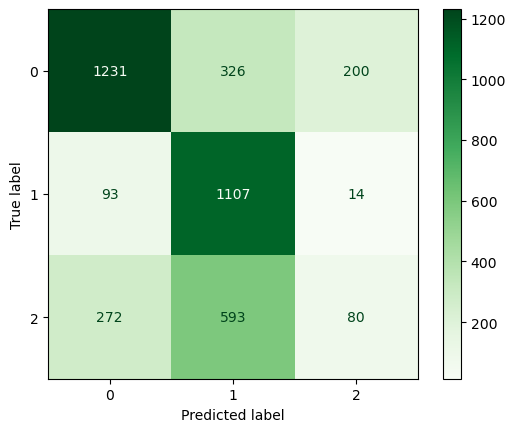

In [37]:
cm = confusion_matrix(mod_df2['genre'], mod_df2['pred_label'])

cm_display = ConfusionMatrixDisplay(cm).plot(cmap = 'Greens')

## Conclusion and Observations
We have achieved a degree of success in our project. While a 62% accuracy score does not seem like a great performance, it is clearly better than pure chance as the below computaions of the within-class performance show. When these are evaluated we can see that the algorithm performs decently on the classification on the 'Folk' and 'Hip-Hop' genres and this simple observation must motivate our furhter enquiries.
- First and most obviously, we observe that the dataset we have used despite our modest cleaning efforts remains unbalanced and this is not in favour of the pop music category. Therefore we should explore incorporating more data in the pop category to improve our training process.
- Another area to explore would be to increase the number of extracted features used in fitting our NMF model. For the purpose of this demonstration we have used a relatively limited number of extracted features compared to the potential total number we could use. We know NMF performs well on high dimensional and even sparse data. Given this we should consider digging into the extensive possibilities for feature engineering to improve performance.
- The final point to be raised concerns domain knowledge around the specific category of 'Pop'. It may be that the algorithm struggles simply because this is not a very well defined category of music in terms of uniqueness and perhaps we should attempt to see how our approach works on an alternate genre.

In conclusion, the preliminary results obtained suggest this is a promising area of investigation that may prove fruitful and is certainly worth further study.

In [75]:
# Accuracy score for Hip-Hop only prediction
accuracy_score(mod_df2[mod_df2['genre']==4]['genre'], mod_df2[mod_df2['genre']==4]['pred_label'])

0.7006260671599317

In [76]:
# Accuracy score for Punk only prediction
accuracy_score(mod_df2[mod_df2['genre']==5]['genre'], mod_df2[mod_df2['genre']==5]['pred_label'])

0.9118616144975288

In [77]:
# Accuracy score for Pop only prediction
accuracy_score(mod_df2[mod_df2['genre']==8]['genre'], mod_df2[mod_df2['genre']==8]['pred_label'])

0.08465608465608465